# Transformer Preliminaries 


## Framing
> GOAL: Create a notebook with proof-of-concepts/examples for each component of the upcoming transformer/Perceiver architecture. 

Objectives: 
 1. Gain familiarity with the code side of transformers.
 2. Create examples of each unfamiliar components of the project. 
 3. Maximize copy-paste-ability. 


## Diverging 
> Things to prototype.

 - [ ] Patch extraction.
	 - [ ] Video.
	 - [ ] Audio. 
	 - [ ] VTT subtitle files. 
 - [ ] Text tokenization/vectorization. 
 - [ ] Implementation of spacetime Fourier features (positional encoding).
 - [ ] Attention blocks (self attention, cross attention).
	 - Should be a `dmodel` or whatever Tensorflow uses. 
 - [ ] Masking for transformer layers. 
 - [ ] Decoder/encoder cold start (cf. Perceiver paper).
 - [ ] How to query latent space for specific spatiotemporal coordinates?
 - [ ] Figure out how to use GPU on Thomson Lab HPC. 

In [213]:
## Import box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [69]:
## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 101
output_size = (240, 360)

## 1: Acquire Dataset

In [70]:
sys.path.append("../src")
import video_loader as vl

In [71]:
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


In [72]:
print(VideoSet)

<BatchDataset element_spec=TensorSpec(shape=(None, 101, 240, 360, 3), dtype=tf.float32, name=None)>


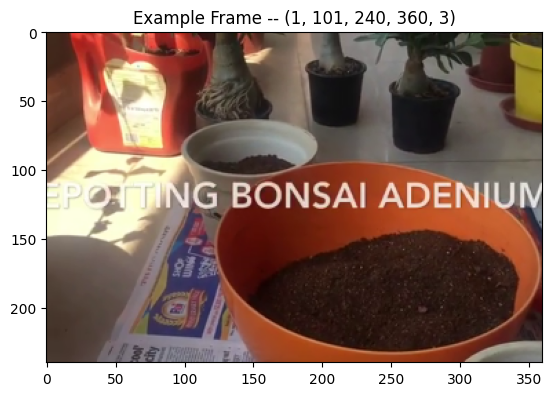

In [73]:
for element in VideoSet:
	plt.imshow(element[0,50,:,:,:])
	plt.title(f"Example Frame -- {element.shape}")
	break

## 2: Make Spacetime Patches (Video)

> Goal: Create array of patches, reshape back into regular video tensor.

 - `PatchedSet`: [batch, num_time_slices, num_height_slices, num_width_slices, num_RGBVals_per_patch]. 
 - `FlatPatchedSet`: [batch, num_patches, num_RGBVals_per_patch]

In [77]:
patch_height = 32
patch_width = 32
patch_duration = 3

ksizes=[1,patch_duration,patch_height,patch_width,1] # 4 duration, 16x16 height-width 

def create_patches(video_tensor, ksizes=[1,4,16,16,1]): 
	"""Converts `video_tensor` into a sequence of patches.
	Input has shape [frames, width, height, channels]

	ksizes=[1,4,16,16,1] -> 4 temporal depth, 16 height/width. 
	"""
	return tf.extract_volume_patches(video_tensor, ksizes,ksizes,"VALID")

PatchedSet = VideoSet.map(lambda x: create_patches(x, ksizes=ksizes))

In [78]:
## PatchedSet now has all the patches, but they aren't fully flattened -- 
# There's a 3072-long vector at every point where there would have been a patch.
# Still gotta add positional encoding and fully flatten out into a 2D matrix. 
PatchedSet # [batchsize, realduration/timepatch, height/heightpatch, width/widthpath, all RGB datum]
		   # RGB data: All RGB values for a patch of size (timedur * heightpatch * widthpatch) * 3 channels.

<MapDataset element_spec=TensorSpec(shape=(None, 33, 7, 11, 9216), dtype=tf.float32, name=None)>

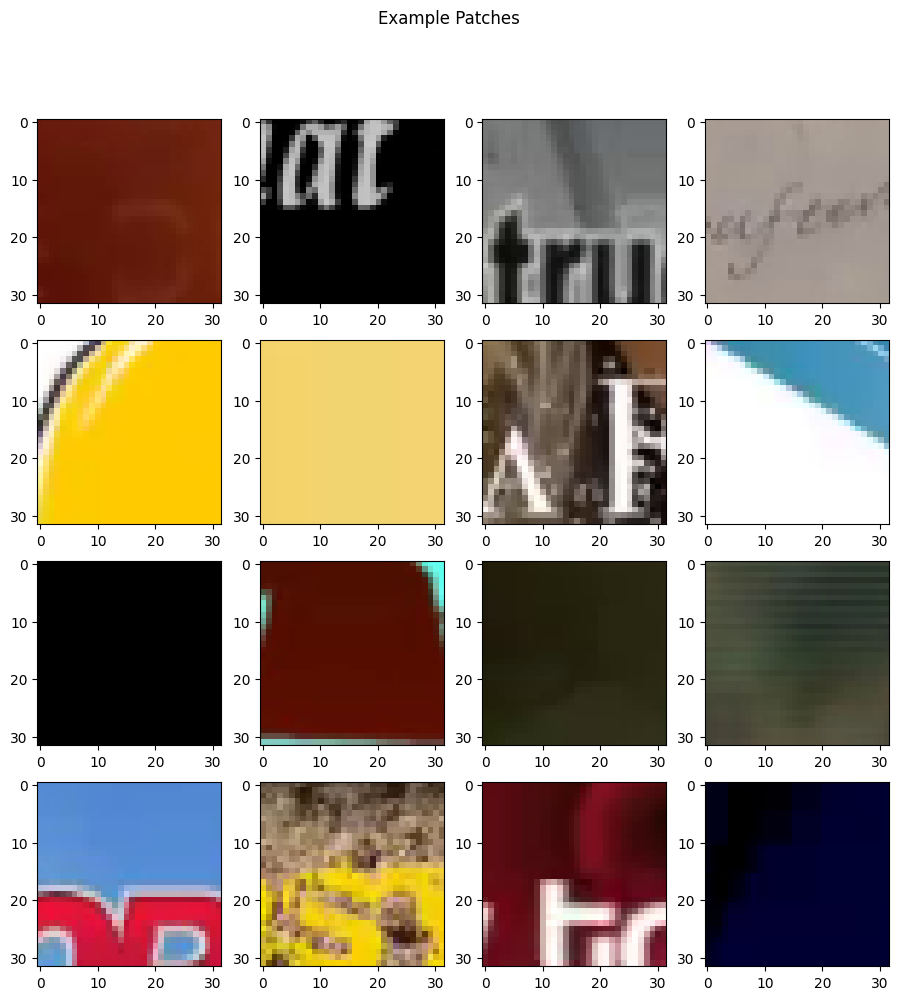

In [80]:
## Let's decode a single spacetime patch

nplots = math.ceil(math.sqrt(len(PatchedSet)))
fig, axs = plt.subplots(nplots, nplots)
fig.set_figheight(11)
fig.set_figwidth(11)

cnt=0
for element in PatchedSet: 
	
	# plt.imshow()tf.reshape(element[0,0,:,:,0]), (16,16,3)
	# print("Element shape: ", element.shape)
	first_patch = element[0,3,3,4,:]
	# print("First patch shape: ", first_patch.shape)
	first_patch = tf.reshape(first_patch, [patch_duration, patch_height, patch_width, 3] ) # time, height, width, channels 
	axs[cnt//nplots, cnt%nplots].imshow(first_patch[2,:,:,:])
	cnt+=1
plt.suptitle("Example Patches")
plt.show()

In [54]:
def unpatch(patch_tensor, ksizes):
	"""Converts a patchified tensor with shape 
		[batch, n_timepatch, n_heightpatch, n_widthpatch, RGBTotal] 
	where RGBTotal = (n_timepatch * n_heightpatch * n_widthpatch) * channels 
	and channels = 3 RGB channels.

	Into a video tensor of shape [batch, nframes, height, width, channels]

	ksizes = [1, patch_time, patch_height, patch_width, 1]
	"""
	... # TODO


In [101]:
def flatten_patched(patch_tensor, batch_size=1):
	""" Flattens the 3D structure of spacetime patches into a [batch, num_patches, patch_len] 
	tensor. Should be applied after positional encoding, generally. 
	"""
	print("Flattening a tensor of shape: ", patch_tensor.shape)
	b, t, h, w, cs = patch_tensor.shape
	return tf.reshape(patch_tensor, [batch_size, t*h*w, cs])

def unflatten_patched(patch_tensor, duration, height, width):
	b, thw, cs = patch_tensor.shape
	assert thw == duration*height*width, "Patch duration*height*width must equal the patch's flattened length!"
	return tf.reshape(patch_tensor, duration, height, width, cs) 

In [102]:
FlatPatchSet = PatchedSet.map(lambda x: flatten_patched(x))
FlatPatchSet

Flattening a tensor of shape:  (None, 33, 7, 11, 9216)


<MapDataset element_spec=TensorSpec(shape=(1, 2541, 9216), dtype=tf.float32, name=None)>

### 2a: Positional Encoding

Let some dimension (e.g., token #) take values $m\in [M]$. Let $x_m = m/M$. $\mu$ is the Nyquist frequency for the Fourier features -- this will be the highest frequency resolvable by the positional encoding. $K$ is the number of frequencies in use. The final positional encoding is then composed of 

$$\begin{pmatrix} \begin{bmatrix} \sin(f_k \pi x_m) \\ \cos(f_k \pi x_m) \end{bmatrix}, f_k \in [1, \mu/2] \\ x_m \end{pmatrix}$$
<!-- $$PE_{(pos, 2i)} = \sin (\frac {2\pi pos} {\lambda_{\max}^{}})$$ -->

This scheme is directly from the Perceiver paper. Notably, we concatenate these positional codes rather than summing them with the input tokens. 

In [104]:
print(VideoSet)
print(PatchedSet)

<BatchDataset element_spec=TensorSpec(shape=(None, 101, 240, 360, 3), dtype=tf.float32, name=None)>
<MapDataset element_spec=TensorSpec(shape=(None, 33, 7, 11, 9216), dtype=tf.float32, name=None)>


In [264]:
def get_spacetime_codes(num_times, num_heights, num_widths, k_space=15, 
		mu_space=20, k_time=64, mu_time=200):
	""" Produces Fourier features for positionally coding x, y, and time 
	coordinates. Separate k,mu values for space and time. 
	
	Returns a tensor to be concatenated with the unflattened patch dataset 
	of shape [1,num_times, num_heights, num_widths, k_space*2*2 + k_time*2 + 3]
	"""
	## 1: Making the x_m array for each. 
	x_m_t = (tf.range(num_times, dtype=tf.float32) / num_times) * 2 - 1
	x_m_h = (tf.range(num_heights, dtype=tf.float32) / num_heights) * 2 - 1
	x_m_w = (tf.range(num_widths, dtype=tf.float32) / num_widths) * 2 - 1

	## 2: Making the f_k's for each. 
	space_fks = tf.range(1, mu_space/2, delta=(mu_space/2 - 1)/k_space, dtype=tf.float32)
	time_fks = tf.range(1, mu_time/2, delta=(mu_time/2 - 1)/k_time, dtype=tf.float32)

	## 3: time, height, and width sine arguments. 
	#  These have dimensions [num positions, numbands]
	t_args = math.pi * tf.expand_dims(x_m_t, axis=1) * tf.expand_dims(time_fks, axis=0)
	h_args = math.pi * tf.expand_dims(x_m_h, axis=1) * tf.expand_dims(space_fks, axis=0)
	w_args = math.pi * tf.expand_dims(x_m_w, axis=1) * tf.expand_dims(space_fks, axis=0)

	# [num positions, num bands]
	t_sin = tf.sin(t_args) 
	h_sin = tf.sin(h_args)
	w_sin = tf.sin(w_args) 
	t_cos = tf.cos(t_args) 
	h_cos = tf.cos(h_args)
	w_cos = tf.cos(w_args) 

	# Combined sin/cos/x_m features 
	t_feats = tf.concat( [t_sin, t_cos, tf.expand_dims(x_m_t, axis=1)], axis=1)
	h_feats = tf.concat( [h_sin, h_cos, tf.expand_dims(x_m_h, axis=1)], axis=1)
	w_feats = tf.concat( [w_sin, w_cos, tf.expand_dims(x_m_w, axis=1)], axis=1)

	# Expanding the dimensions and repeating -- [t,h,w,guh] order
	t_feats = tf.expand_dims(t_feats, 1)
	t_feats = tf.repeat(t_feats, num_widths, axis=1) # eventually width
	t_feats = tf.expand_dims(t_feats, 1)
	t_feats = tf.repeat(t_feats, num_heights, axis=1)

	h_feats = tf.expand_dims(h_feats, 0) 
	h_feats = tf.repeat(h_feats, num_times, axis=0) # directly to time
	h_feats = tf.expand_dims(h_feats, 2)
	h_feats = tf.repeat(h_feats, num_widths, axis=2) # directly to width

	w_feats = tf.expand_dims(w_feats, 0)
	w_feats = tf.repeat(w_feats, num_heights, axis=0) # eventually height 
	w_feats = tf.expand_dims(w_feats, 0)
	w_feats = tf.repeat(w_feats, num_times, axis=0) # directly time

	# Repeating each feature set along the proper dimensions 
	


	## 4: Gluing everything together -> fourier feature tensor 
	#  Each position in the tensor has size: (k_space*4) + k_time * 2 + 3
	# 	 - 2 * k_space for sin/cos of height 
	# 	 - 2 * k_space for sin/cos of width 
	# 	 - 2 * k_time for sin/cos of time 
	# 	 - 1 for x_m_t, 1 for x_m_h, 1 for x_m_w -- the indices \in [-1,1] 
	feature_dim = k_space * 4 + k_time * 2 + 3 

	fourier_tensor = tf.concat([t_feats, h_feats, w_feats], axis=-1)

	assert feature_dim == fourier_tensor.shape[-1]

	return fourier_tensor

In [266]:
_, n_times, n_heights, n_widths, _ = PatchedSet.element_spec.shape
# n_times = 100
# mu_time = 1000
fourier_tensor = get_spacetime_codes(n_times, n_heights, n_widths)

In [268]:
fourier_tensor.shape

TensorShape([33, 7, 11, 191])

In [258]:
w_feats.shape

TensorShape([33, 7, 11, 31])

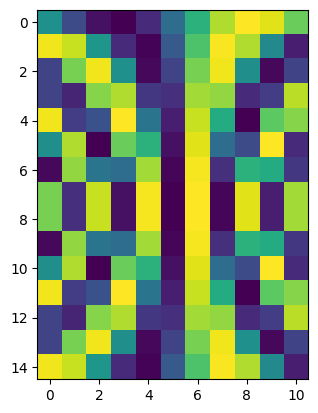

In [145]:
plt.imshow(x_sin)